# Cassandra datasource

### 1. Init and check PySpark configuration

In [1]:
!pip list | grep spark

findspark                   2.0.1
pyspark                     3.5.4


In [2]:
import uuid
from typing import Literal

import findspark
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, when, udf
from pyspark.sql.types import BooleanType, StringType, IntegerType

import measurment_tools as mt

In [3]:
findspark.init()

spark = SparkSession.builder.appName("test").getOrCreate()
df = spark.createDataFrame([(1, "Alice"), (2, "Bob")], ["id", "name"])
df.show()

25/05/11 23:47:29 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+---+-----+
| id| name|
+---+-----+
|  1|Alice|
|  2|  Bob|
+---+-----+



### 2. Create a Snowflake session & read data

In [12]:
import snowflake.connector as sf

conn = sf.connect(
    user="test",
    password="test",
    account="test",
    host="snowflake.localhost.localstack.cloud",
)

conn.cursor().execute("CREATE WAREHOUSE IF NOT EXISTS test_warehouse")
conn.cursor().execute("CREATE DATABASE IF NOT EXISTS testdb")
conn.cursor().execute("USE DATABASE testdb")
conn.cursor().execute("CREATE SCHEMA IF NOT EXISTS testschema")

OperationalError: 250001: Could not connect to Snowflake backend after 2 attempt(s).Aborting

In [11]:
from pyspark.sql import SparkSession

SNOWFLAKE_SOURCE_NAME = "net.snowflake.spark.snowflake"
sfOptions = {
    "sfURL": "snowflake.localhost.localstack.cloud",
    "sfUser": "test",
    "sfPassword": "test",
    "sfDatabase": "testdb",
    "sfSchema": "testschema",
    "sfWarehouse": "test_warehouse",
    "sfRole": "sysadmin",
    "sfAccount": "test"
}

spark = SparkSession.builder \
    .appName("PySpark LocalStack Snowflake Test") \
    .getOrCreate()

df = spark.read.format(SNOWFLAKE_SOURCE_NAME).options(**sfOptions).option("query", "SELECT 1").load()
df.show()

25/05/11 23:48:44 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
25/05/11 23:48:44 ERROR SessionUtil: Failed to open new session for user: test, host: snowflake.localhost.localstack.cloud. Error: 
25/05/11 23:48:44 ERROR SessionUtil: Failed to open new session for user: test, host: snowflake.localhost.localstack.cloud. Error: 


Py4JJavaError: An error occurred while calling o386.load.
: net.snowflake.client.jdbc.SnowflakeSQLException: 
	at net.snowflake.client.core.SessionUtil.newSession(SessionUtil.java:799)
	at net.snowflake.client.core.SessionUtil.openSession(SessionUtil.java:312)
	at net.snowflake.client.core.SFSession.open(SFSession.java:715)
	at net.snowflake.client.jdbc.DefaultSFConnectionHandler.initialize(DefaultSFConnectionHandler.java:129)
	at net.snowflake.client.jdbc.DefaultSFConnectionHandler.initializeConnection(DefaultSFConnectionHandler.java:102)
	at net.snowflake.client.jdbc.SnowflakeConnectionV1.initConnectionWithImpl(SnowflakeConnectionV1.java:146)
	at net.snowflake.client.jdbc.SnowflakeConnectionV1.<init>(SnowflakeConnectionV1.java:123)
	at net.snowflake.client.jdbc.SnowflakeDriver.connect(SnowflakeDriver.java:231)
	at java.sql/java.sql.DriverManager.getConnection(DriverManager.java:683)
	at java.sql/java.sql.DriverManager.getConnection(DriverManager.java:191)
	at net.snowflake.spark.snowflake.ServerConnection$.createJDBCConnection(ServerConnection.scala:255)
	at net.snowflake.spark.snowflake.ServerConnection$.getServerConnection(ServerConnection.scala:130)
	at net.snowflake.spark.snowflake.JDBCWrapper.getConnector(SnowflakeJDBCWrapper.scala:111)
	at net.snowflake.spark.snowflake.SnowflakeRelation.$anonfun$schema$1(SnowflakeRelation.scala:61)
	at scala.Option.getOrElse(Option.scala:189)
	at net.snowflake.spark.snowflake.SnowflakeRelation.schema$lzycompute(SnowflakeRelation.scala:58)
	at net.snowflake.spark.snowflake.SnowflakeRelation.schema(SnowflakeRelation.scala:57)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:434)
	at org.apache.spark.sql.DataFrameReader.loadV1Source(DataFrameReader.scala:229)
	at org.apache.spark.sql.DataFrameReader.$anonfun$load$2(DataFrameReader.scala:211)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:211)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:172)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)


In [5]:
# df = spark.read.csv("data/airline.csv.shuffle", header=True, inferSchema=True)
df = spark.read.csv("data/first_100_airline.csv", header=True, inferSchema=True)

In [6]:
df.show(2, truncate=False)

25/05/11 23:47:37 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------------+-------+--------+-------+----------+----------+--------------+----------------+---------+------------+---------+----------+--------+-------+----+--------+--------+---------+-----------------+-----+--------+------+-------------+-------+------+-------+-------------+------------+----+
|ActualElapsedTime|AirTime|ArrDelay|ArrTime|CRSArrTime|CRSDepTime|CRSElapsedTime|CancellationCode|Cancelled|CarrierDelay|DayOfWeek|DayofMonth|DepDelay|DepTime|Dest|Distance|Diverted|FlightNum|LateAircraftDelay|Month|NASDelay|Origin|SecurityDelay|TailNum|TaxiIn|TaxiOut|UniqueCarrier|WeatherDelay|Year|
+-----------------+-------+--------+-------+----------+----------+--------------+----------------+---------+------------+---------+----------+--------+-------+----+--------+--------+---------+-----------------+-----+--------+------+-------------+-------+------+-------+-------------+------------+----+
|53               |32     |-8      |1642   |1650      |1545      |65            |NA           

### 3. Data preprocessing

- generate primary key
- Replace 'NA' with NULL
- CamelCase -> snake_case due to insensitive nature of Cassandra

In [7]:
def generate_uuid():
    """Generate a random UUID for primary key"""
    return str(uuid.uuid4())

uuid_udf = udf(generate_uuid, StringType())

# add UUID column
df = df.withColumn("id", uuid_udf())

# replace all 'NA' values with None
df = df.replace('NA', None)

# convert column names to match Cassandra schema
df = df.select(
    col("id"),
    col("Year").cast(IntegerType()).alias("year"),
    col("Month").cast(IntegerType()).alias("month"),
    col("DayofMonth").cast(IntegerType()).alias("day_of_month"),
    col("DayOfWeek").cast(IntegerType()).alias("day_of_week"),
    col("DepTime").cast(IntegerType()).alias("dep_time"),
    col("CRSDepTime").cast(IntegerType()).alias("crs_dep_time"),
    col("ArrTime").cast(IntegerType()).alias("arr_time"),
    col("CRSArrTime").cast(IntegerType()).alias("crs_arr_time"),
    col("UniqueCarrier").cast(StringType()).alias("unique_carrier"),
    col("FlightNum").cast(IntegerType()).alias("flight_num"),
    col("TailNum").cast(StringType()).alias("tail_num"),
    col("ActualElapsedTime").cast(IntegerType()).alias("actual_elapsed_time"),
    col("CRSElapsedTime").cast(IntegerType()).alias("crs_elapsed_time"),
    col("AirTime").cast(IntegerType()).alias("air_time"),
    col("ArrDelay").cast(IntegerType()).alias("arr_delay"),
    col("DepDelay").cast(IntegerType()).alias("dep_delay"),
    col("Origin").cast(StringType()).alias("origin"),
    col("Dest").cast(StringType()).alias("dest"),
    col("Distance").cast(IntegerType()).alias("distance"),
    col("TaxiIn").cast(IntegerType()).alias("taxi_in"),
    col("TaxiOut").cast(IntegerType()).alias("taxi_out"),
    col("Cancelled").cast(BooleanType()).alias("cancelled"),
    col("CancellationCode").cast(StringType()).alias("cancellation_code"),
    col("Diverted").cast(BooleanType()).alias("diverted"),
    col("CarrierDelay").cast(IntegerType()).alias("carrier_delay"),
    col("WeatherDelay").cast(IntegerType()).alias("weather_delay"),
    col("NASDelay").cast(IntegerType()).alias("nas_delay"),
    col("SecurityDelay").cast(IntegerType()).alias("security_delay"),
    col("LateAircraftDelay").cast(IntegerType()).alias("late_aircraft_delay")
)

In [8]:
df.dtypes

[('id', 'string'),
 ('year', 'int'),
 ('month', 'int'),
 ('day_of_month', 'int'),
 ('day_of_week', 'int'),
 ('dep_time', 'int'),
 ('crs_dep_time', 'int'),
 ('arr_time', 'int'),
 ('crs_arr_time', 'int'),
 ('unique_carrier', 'string'),
 ('flight_num', 'int'),
 ('tail_num', 'string'),
 ('actual_elapsed_time', 'int'),
 ('crs_elapsed_time', 'int'),
 ('air_time', 'int'),
 ('arr_delay', 'int'),
 ('dep_delay', 'int'),
 ('origin', 'string'),
 ('dest', 'string'),
 ('distance', 'int'),
 ('taxi_in', 'int'),
 ('taxi_out', 'int'),
 ('cancelled', 'boolean'),
 ('cancellation_code', 'string'),
 ('diverted', 'boolean'),
 ('carrier_delay', 'int'),
 ('weather_delay', 'int'),
 ('nas_delay', 'int'),
 ('security_delay', 'int'),
 ('late_aircraft_delay', 'int')]

### 5. Load data into Snowflake (skipped creation - done on Cassandra container for now)
- Create a table
- Load data into the table
- Query the data from the table

In [9]:
# from cassandra.cluster import Cluster
# from cassandra.query import SimpleStatement
# from cassandra import ConsistencyLevel
# cluster = Cluster(['localhost'])
# session = cluster.connect() 
# session.set_keyspace('airline_data')
# create_table_query = """
# CREATE TABLE IF NOT EXISTS flights (
#     id UUID PRIMARY KEY,
#     year INT,
#     month INT,
#     day_of_month INT,
#     day_of_week INT,
#     dep_time INT,
#     crs_dep_time INT,
#     arr_time INT,
#     crs_arr_time INT,
#     unique_carrier TEXT,
#     flight_num TEXT,
#     tail_num TEXT,
#     actual_elapsed_time FLOAT,
#     crs_elapsed_time FLOAT,
#     air_time FLOAT,
#     arr_delay FLOAT,
#     dep_delay FLOAT,
#     origin TEXT,
#     dest TEXT,
#     distance FLOAT,
#     taxi_in FLOAT,
#     taxi_out FLOAT,
#     cancelled BOOLEAN,
#     cancellation_code TEXT,
#     diverted BOOLEAN,
#     carrier_delay FLOAT,
#     weather_delay FLOAT,
#     nas_delay FLOAT,
#     security_delay FLOAT,
#     late_aircraft_delay FLOAT
# )"""

# session.execute(create_table_query)

# @mt.perf_timer
# def read_from_cassandra():
#     """Odczyt danych z Cassandra przy użyciu DataFrame"""
#     return spark.read \
#         .format("org.apache.spark.sql.cassandra") \
#         .options(table="flights", keyspace="airline_data") \
#         .load()

# @mt.perf_timer
# def write_to_cassandra_rdd(rdd):
#     """Zapis danych do Cassandra przy użyciu RDD"""
#     rdd.saveToCassandra("airline_data", "flights")

# @mt.perf_timer
# def read_from_cassandra_rdd():
#     """Odczyt danych z Cassandra przy użyciu RDD"""
#     return spark.sparkContext \
#         .cassandraTable("airline_data", "flights")
df.agg(count("*")).show()

+--------+
|count(1)|
+--------+
|     100|
+--------+



In [10]:
@mt.perf_timer
def load_data():
    """Load DataFrame to Cassandra"""
    df.write \
        .format("net.snowflake.spark.snowflake") \
        .mode("append") \
        .options(**sfOptions) \
        .option("dbtable", "flights") \
        .save()

    print("Data successfully written to Snowflake!")

load_data()

25/05/11 23:47:39 ERROR SessionUtil: Failed to open new session for user: test, host: snowflake.localhost.localstack.cloud. Error: 
25/05/11 23:47:39 ERROR SessionUtil: Failed to open new session for user: test, host: snowflake.localhost.localstack.cloud. Error: 


Py4JJavaError: An error occurred while calling o372.save.
: net.snowflake.client.jdbc.SnowflakeSQLException: 
	at net.snowflake.client.core.SessionUtil.newSession(SessionUtil.java:799)
	at net.snowflake.client.core.SessionUtil.openSession(SessionUtil.java:312)
	at net.snowflake.client.core.SFSession.open(SFSession.java:715)
	at net.snowflake.client.jdbc.DefaultSFConnectionHandler.initialize(DefaultSFConnectionHandler.java:129)
	at net.snowflake.client.jdbc.DefaultSFConnectionHandler.initializeConnection(DefaultSFConnectionHandler.java:102)
	at net.snowflake.client.jdbc.SnowflakeConnectionV1.initConnectionWithImpl(SnowflakeConnectionV1.java:146)
	at net.snowflake.client.jdbc.SnowflakeConnectionV1.<init>(SnowflakeConnectionV1.java:123)
	at net.snowflake.client.jdbc.SnowflakeDriver.connect(SnowflakeDriver.java:231)
	at java.sql/java.sql.DriverManager.getConnection(DriverManager.java:683)
	at java.sql/java.sql.DriverManager.getConnection(DriverManager.java:191)
	at net.snowflake.spark.snowflake.ServerConnection$.createJDBCConnection(ServerConnection.scala:255)
	at net.snowflake.spark.snowflake.ServerConnection$.getServerConnection(ServerConnection.scala:130)
	at net.snowflake.spark.snowflake.JDBCWrapper.getConnector(SnowflakeJDBCWrapper.scala:111)
	at net.snowflake.spark.snowflake.io.StageWriter$.writeToStage(StageWriter.scala:210)
	at net.snowflake.spark.snowflake.io.package$.writeRDD(package.scala:50)
	at net.snowflake.spark.snowflake.SnowflakeWriter.save(SnowflakeWriter.scala:110)
	at net.snowflake.spark.snowflake.DefaultSource.createRelation(DefaultSource.scala:113)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:48)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:75)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:73)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.executeCollect(commands.scala:84)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:437)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:85)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:83)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:142)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:869)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:391)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:364)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:251)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)


# 6. Questions

#### 6.1. When is the best time of day/day of week/time of year to fly to minimise delays?

In [11]:
# dataframe_copied with TimeOfDay
df_cp_tod = df.withColumn("time_of_day", when(col("dep_time") < 1200, "morning") \
                          .when(col("dep_time") < 1800, "afternoon") \
                          .otherwise("evening"))

@mt.perf_timer
def give_answer_61(df, by: Literal['time_of_day', 'day_of_week', 'month']):
    """Aggregate delay over datetimes"""
    df.groupBy(by) \
        .agg(avg("arr_delay").alias("avg_arr_delay")) \
        .orderBy("avg_arr_delay") \
    .show()

In [12]:
give_answer_61(df_cp_tod, by="time_of_day")

+-----------+------------------+
|time_of_day|     avg_arr_delay|
+-----------+------------------+
|    morning| 2.514619133111054|
|  afternoon| 7.312166866093767|
|    evening|15.034083193771783|
+-----------+------------------+

Function 'give_answer_61' took 8.50906 seconds to execute.


In [13]:
give_answer_61(df_cp_tod, by="day_of_week")

+-----------+------------------+
|day_of_week|     avg_arr_delay|
+-----------+------------------+
|          6|3.9948754336171555|
|          2| 6.229899585703251|
|          7| 6.557286690673918|
|          1| 6.598887730274591|
|          3| 7.191530584002214|
|          4| 9.112538612749228|
|          5| 9.956747647802276|
+-----------+------------------+

Function 'give_answer_61' took 6.82280 seconds to execute.


In [14]:
give_answer_61(df_cp_tod, by="month")

+-----+------------------+
|month|     avg_arr_delay|
+-----+------------------+
|    9|3.4376907426246186|
|    4| 4.758896241728056|
|   10| 5.059097254536994|
|   11| 5.576995129261896|
|    5| 5.587605016437355|
|    2| 7.695141272775284|
|    8| 7.752554050843431|
|    3| 7.970952322588553|
|    1| 8.195403742308175|
|    7|  9.30916344010325|
|    6|  9.61770871870761|
|   12|10.537173396674584|
+-----+------------------+

Function 'give_answer_61' took 6.36182 seconds to execute.



[Stage 18:=======================================================>(89 + 1) / 90]



#### 6.2. Do older planes suffer more delays?

In [15]:
@mt.perf_timer
def give_answer_62(df):
    """Plot average arrival delay by year"""
    # calc avg arrival delay by year
    avg_delay_df = df.groupBy("year") \
        .agg(avg("arr_delay").alias("avg_arr_delay")) \
        .orderBy("year")
    
    # plot pandas df 
    pandas_df = avg_delay_df.toPandas()
    
    x = pandas_df["year"]
    y = pandas_df["avg_arr_delay"]
    
    plt.figure(figsize=(10, 6))
    plt.bar(x, y, color="blue", alpha=0.7, label="Average Delay")
    
    # add a trend line using numpy.polyfit
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), color="red", linestyle="--", label="Trend Line")
    
    plt.title("Average Arrival Delay by Year")
    plt.xlabel("Year")
    plt.ylabel("Average Arrival Delay (minutes)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

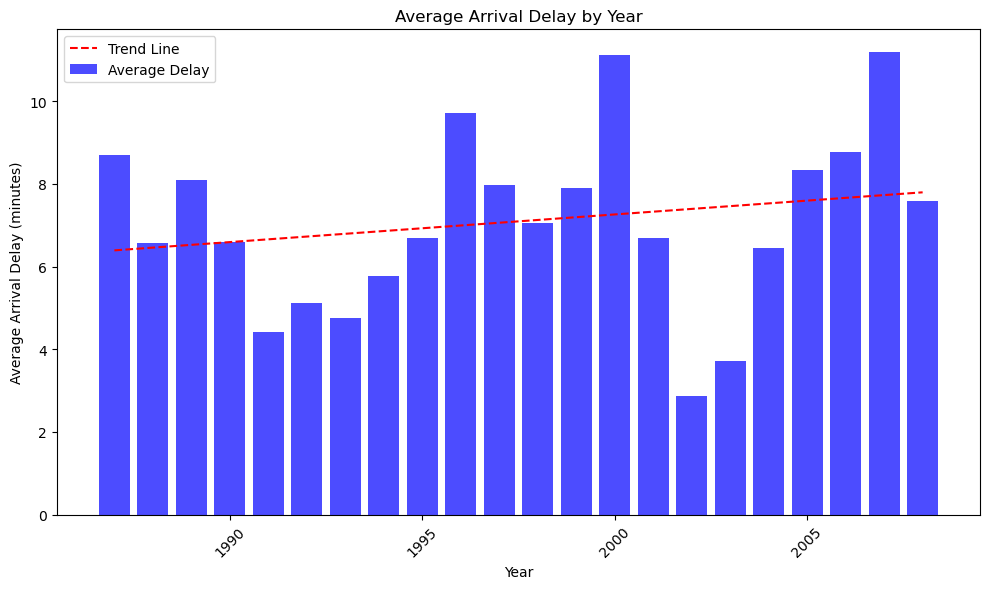

Function 'give_answer_62' took 7.28440 seconds to execute.


In [16]:
give_answer_62(df)

#### 6.3. How does the number of people flying between different locations change over time?

In [17]:
@mt.perf_timer
def give_answer_63(df):
    """Aggregate flight count over years and months"""
    # group by year, month, origin, and destination
    flight_trends = df.groupBy("year", "month", "origin", "dest") \
                    .agg(count("*").alias("flight_count"))

    # sort to observe trends
    flight_trends = flight_trends.orderBy("year", "month")
    flight_trends.show()

In [18]:
give_answer_63(df)

+----+-----+------+----+------------+
|year|month|origin|dest|flight_count|
+----+-----+------+----+------------+
|1987|   10|   DTW| DEN|           2|
|1987|   10|   DEN| ORD|           1|
|1987|   10|   BOS| DCA|           1|
|1987|   10|   MSY| DEN|           1|
|1987|   10|   ORD| CLT|           1|
|1987|   10|   PHX| ELP|           1|
|1987|   10|   MSP| MLI|           1|
|1987|   10|   TPA| BDL|           1|
|1987|   10|   SJC| LAX|           3|
|1987|   10|   SFO| LAX|           4|
|1987|   10|   PHL| ORF|           1|
|1987|   10|   PWM| PIT|           2|
|1987|   10|   IAH| CRP|           1|
|1987|   10|   OMA| DSM|           1|
|1987|   10|   DAB| ATL|           1|
|1987|   10|   DEN| OKC|           1|
|1987|   10|   ATL| BNA|           1|
|1987|   10|   PHX| ABQ|           1|
|1987|   10|   ATL| MCI|           1|
|1987|   10|   IAD| BOS|           1|
+----+-----+------+----+------------+
only showing top 20 rows

Function 'give_answer_63' took 7.14307 seconds to execute.


#### 6.4. How well does weather predict plane delays?

In [19]:
@mt.perf_timer
def give_answer_64(df):
    """Measure correlation between weather delay and arrival delay"""
    # replace NA as no delay
    df = df.fillna({"weather_delay": 0})

    # calc correlation
    correlation = df.stat.corr("weather_delay", "arr_delay")
    print(f"Correlation between weather_delay and arr_delay: {correlation}")

In [20]:
give_answer_64(df)

Correlation between weather_delay and arr_delay: 0.17815595168482354
Function 'give_answer_64' took 6.40494 seconds to execute.


#### 6.5. Can you detect cascading failures as delays in one airport create delays in others? Are there critical links in the system?

In [21]:
@mt.perf_timer
def give_answer_65(df):
    """Try to find a correlation between arrival and departure delays for flights exiting the same airport"""
    joined_df = df.alias("a").join(
        df.alias("b"),
        col("a.dest") == col("b.origin"),
        "inner"
    ).select(
        col("a.origin").alias("origin_airport"),
        col("a.dest").alias("connecting_airport"),
        col("b.dest").alias("final_airport"),
        col("a.arr_delay").alias("arrival_delay"),
        col("b.dep_delay").alias("departure_delay")
    )

    # correlation
    correlation = joined_df.stat.corr("arrival_delay", "departure_delay")
    print(f"Correlation between arrival and departure delays: {correlation:.4f}")

In [22]:
give_answer_65(df)

Correlation between arrival and departure delays: 0.0027
Function 'give_answer_65' took 24.99875 seconds to execute.
